# Carregamento dos dados

In [1]:
from pandas import read_csv

url = "./SA_heart.csv"
dataset = read_csv(url, header=0, usecols=[i+1 for i in range(10)])

dataset.head(5)

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


# Preparação dos dados

### One hot encode

In [2]:
from pandas import get_dummies
# one-hot encode
# fonte: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
dataset = get_dummies(dataset)
dataset.head(5)

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd,famhist_Absent,famhist_Present
0,160,12.00,5.73,23.11,49,25.30,97.20,52,1,0,1
1,144,0.01,4.41,28.61,55,28.87,2.06,63,1,1,0
2,118,0.08,3.48,32.28,52,29.14,3.81,46,0,0,1
3,170,7.50,6.41,38.03,51,31.99,24.26,58,1,0,1
4,134,13.60,3.50,27.78,60,25.99,57.34,49,1,0,1


### Entradas, saídas e conversão de dataframe para numpy array

In [3]:
import numpy as np

# extração da variável a ser predita
y = np.array(dataset['chd'])
dataset = dataset.drop('chd', axis=1)

# armazenamento do nome de cada variável preditora para uso futuro
X_names = list(dataset.columns)

# conversão para numpy array
X = np.array(dataset)

### Separação dos dados em treino e validação

In [4]:
from sklearn.model_selection import train_test_split

# 90% para treino e 10% para validação
X_train, X_validation, Y_train, Y_validation = train_test_split(
        X, y, test_size=0.10, random_state=1)

# Análise estatística inicial dos dados

### Quantidades médias

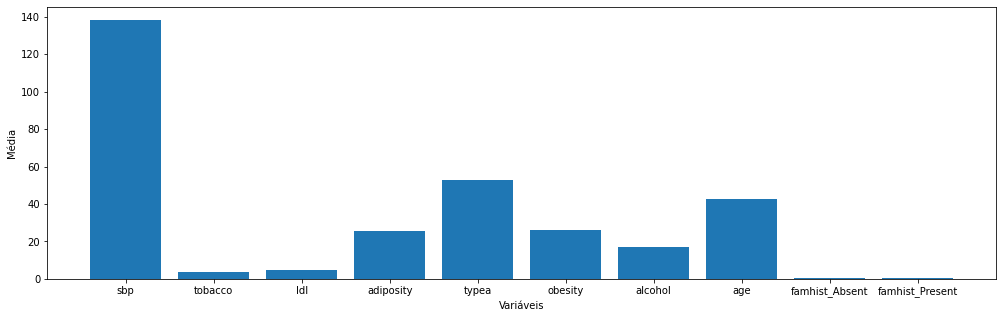

In [5]:
from matplotlib import pyplot

pyplot.figure(figsize=(17,5))
pyplot.bar([i+1 for i in range(10)], [f.mean() for f in X.transpose()], tick_label=X_names, width=0.8)
pyplot.xlabel('Variáveis')
pyplot.ylabel('Média')
pyplot.show()

### Desvio padrão

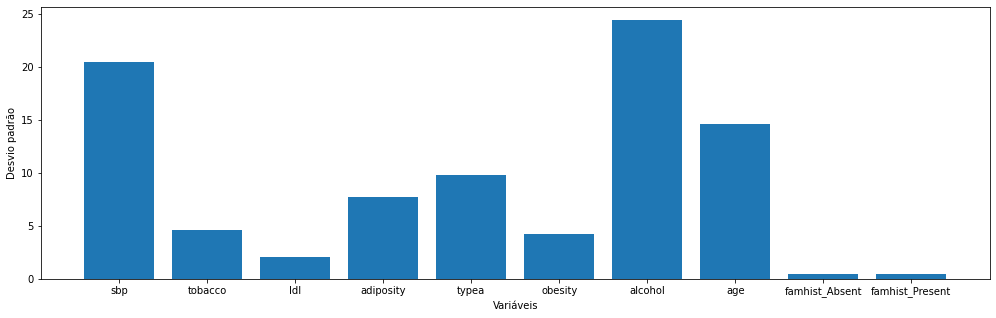

In [6]:
pyplot.figure(figsize=(17,5))
pyplot.bar([i+1 for i in range(10)], [f.std() for f in X.transpose()], tick_label=X_names, width=0.8)
pyplot.xlabel('Variáveis')
pyplot.ylabel('Desvio padrão')
pyplot.show()

# Função de avaliação dos algoritmos

Imprimirá uma matriz de confusão e um gráfico ROC (juntamente do valor de AUC).

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

def evaluate(Y_validation, predictions):
    # Matriz de confusão
    # fonte:  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions
    ConfusionMatrixDisplay.from_predictions(Y_validation, predictions)
    pyplot.show()

    # Curva ROC AUC
    # fonte: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html
    fpr, tpr, thresholds = roc_curve(Y_validation, predictions)
    
    # cálculo do valor AUC
    roc_auc = auc(fpr, tpr)
    
    # plotagem da curva ROC AUC
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()
    pyplot.show()

# Algoritmos

## 1 - Árvore de decisão (ID3)

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Árvore de decisão (ID3) com 10 rodadas de validação cruzada
# fonte: https://machinelearningmastery.com/machine-learning-in-python-step-by-step/

# instanciação do modelo
model = DecisionTreeClassifier(criterion='entropy')

# validação cruzada em 10 rodadas
kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_results = cross_val_score(model, X_train, Y_train, cv=kfold)

# treinamento do modelo
model.fit(X_train, Y_train)

# predições 
predictions = model.predict(X_validation)

#### Variáveis mais importantes

In [9]:
# Impressão das duas variáveis mais importantes
# fonte: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# lista numérica de variáveis mais importantes gerada pelo scikitlearn 
importances = list(model.feature_importances_)

# lista de tuplas com nomes da variável e sua importancia
X_importances = [(X, round(importance, 2)) for X, importance in zip(X_names, importances)]

# ordenação
X_importances = sorted(X_importances, key = lambda x: x[1], reverse = True)

# impressão das duas variáveis mais importantes
for par in X_importances:
    print('{:20} Importância: {}'.format(*par))

age                  Importância: 0.23
typea                Importância: 0.14
alcohol              Importância: 0.14
ldl                  Importância: 0.12
obesity              Importância: 0.11
tobacco              Importância: 0.08
adiposity            Importância: 0.08
sbp                  Importância: 0.06
famhist_Present      Importância: 0.04
famhist_Absent       Importância: 0.0


#### Resultados para avaliação

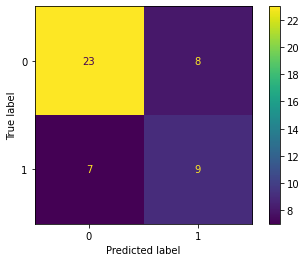

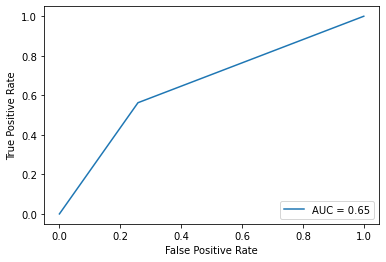

In [10]:
evaluate(Y_validation, predictions)

### Melhorando o modelo

In [11]:
# guardando nome das colunas com 5% de importância ou menos
least_important = []
for X in X_importances:
    if X[1] <= 0.05:
        least_important.append(X[0])

# retirando as colunas do conjunto de dados
limited_dataset = dataset.drop(least_important, axis=1)

# extraindo novamente as variáveis preditoras com seus nomes
new_X_names = list(limited_dataset.columns)
new_X = np.array(limited_dataset)

# 90% para treino e 10% para validação
new_X_train, new_X_validation, new_Y_train, new_Y_validation = train_test_split(
        new_X, y, test_size=0.10, random_state=1)

# validação cruzada em 10 rodadas
kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_results = cross_val_score(model, new_X_train, new_Y_train, cv=kfold)

# treinamento do modelo
model.fit(new_X_train, new_Y_train)

# predições 
predictions = model.predict(new_X_validation)

#### Variáveis mais importantes

In [12]:
# Impressão das duas variáveis mais importantes
# fonte: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# lista numérica de variáveis mais importantes gerada pelo scikitlearn 
importances = list(model.feature_importances_)

# lista de tuplas com nomes da variável e sua importancia
X_importances = [(X, round(importance, 2)) for X, importance in zip(new_X_names, importances)]

# ordenação
X_importances = sorted(X_importances, key = lambda x: x[1], reverse = True)

# impressão das duas variáveis mais importantes
for par in X_importances:
    print('{:20} Importância: {}'.format(*par))

age                  Importância: 0.23
ldl                  Importância: 0.19
obesity              Importância: 0.17
typea                Importância: 0.14
alcohol              Importância: 0.09
tobacco              Importância: 0.07
adiposity            Importância: 0.06
sbp                  Importância: 0.05


#### Resultados para avaliação

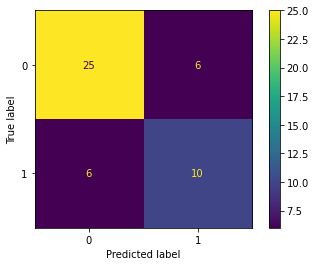

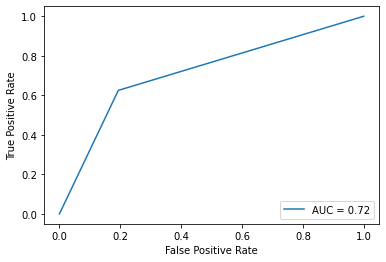

In [13]:
evaluate(new_Y_validation, predictions)

## 2 - Floresta randômica utilizando todas as variáveis preditoras

In [14]:
from sklearn.ensemble import RandomForestClassifier
    
# Floresta randômica com 10 rodadas de validação cruzada
# fonte: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

# instanciação do modelo
# com 100 árvores e utilizando todas as variáveis preditoras
model = RandomForestClassifier(
    criterion='entropy', n_estimators=100, max_features=None)

# validação cruzada em 10 rodadas
kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_results = cross_val_score(model, X_train, Y_train, cv=kfold)

# treinamento do modelo
model.fit(X_train, Y_train)

# predições
predictions = model.predict(X_validation)

#### Variáveis mais importantes

In [15]:
# Impressão das duas variáveis mais importantes
# fonte: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# lista numérica de variáveis mais importantes gerada pelo scikitlearn 
importances = list(model.feature_importances_)

# lista de tuplas com nomes da variável e sua importancia
X_importances = [(X, round(importance, 2)) for X, importance in zip(X_names, importances)]

# ordenação
X_importances = sorted(X_importances, key = lambda x: x[1], reverse = True)

# impressão das duas variáveis mais importantes
for par in X_importances:
    print('{:20} Importância: {}'.format(*par))

age                  Importância: 0.2
tobacco              Importância: 0.13
ldl                  Importância: 0.13
adiposity            Importância: 0.11
typea                Importância: 0.11
obesity              Importância: 0.11
sbp                  Importância: 0.1
alcohol              Importância: 0.08
famhist_Absent       Importância: 0.02
famhist_Present      Importância: 0.02


#### Resultados para avaliação

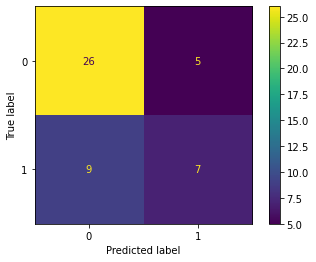

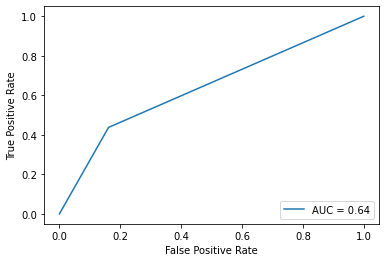

In [16]:
evaluate(Y_validation, predictions)

### Melhorando o modelo

In [17]:
# guardando nome das colunas com 5% de importância ou menos
least_important = []
for X in X_importances:
    if X[1] <= 0.1:
        least_important.append(X[0])

# retirando as colunas do conjunto de dados
limited_dataset = dataset.drop(least_important, axis=1)

# extraindo novamente as variáveis preditoras com seus nomes
new_X_names = list(limited_dataset.columns)
new_X = np.array(limited_dataset)

# 90% para treino e 10% para validação
new_X_train, new_X_validation, new_Y_train, new_Y_validation = train_test_split(
        new_X, y, test_size=0.10, random_state=1)

# validação cruzada em 10 rodadas
kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_results = cross_val_score(model, new_X_train, new_Y_train, cv=kfold)

# treinamento do modelo
model.fit(new_X_train, new_Y_train)

# predições 
predictions = model.predict(new_X_validation)

#### Variáveis mais importantes

In [18]:
# Impressão das duas variáveis mais importantes
# fonte: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# lista numérica de variáveis mais importantes gerada pelo scikitlearn 
importances = list(model.feature_importances_)

# lista de tuplas com nomes da variável e sua importancia
X_importances = [(X, round(importance, 2)) for X, importance in zip(new_X_names, importances)]

# ordenação
X_importances = sorted(X_importances, key = lambda x: x[1], reverse = True)

# impressão das duas variáveis mais importantes
for par in X_importances:
    print('{:20} Importância: {}'.format(*par))

age                  Importância: 0.22
ldl                  Importância: 0.18
tobacco              Importância: 0.17
obesity              Importância: 0.15
adiposity            Importância: 0.14
typea                Importância: 0.14


#### Resultados para avaliação

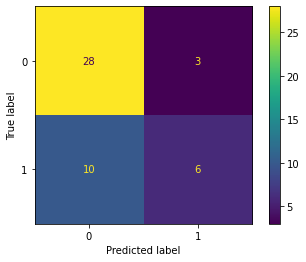

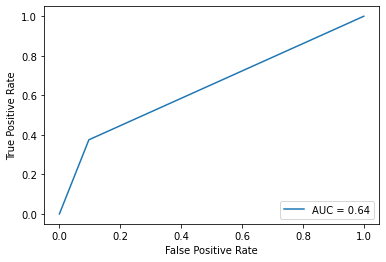

In [19]:
evaluate(new_Y_validation, predictions)

## 3 - Floresta randômica utilizando o quadrado das variáveis preditoras

In [20]:
from sklearn.model_selection import StratifiedKFold

# instanciação do modelo
model = RandomForestClassifier(criterion='entropy', random_state=1 ,n_estimators=100, max_features='sqrt')

# validação cruzada
kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='roc_auc')

# treinamento dos dados
model.fit(X_train, Y_train)

# predições
predictions = model.predict(X_validation)

#### Variáveis mais importantes

In [21]:
# Impressão das duas variáveis mais importantes
# fonte: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# lista numérica de variáveis mais importantes gerada pelo scikitlearn 
importances = list(model.feature_importances_)

# lista de tuplas com nomes da variável e sua importancia
X_importances = [(X, round(importance, 2)) for X, importance in zip(X_names, importances)]

# ordenação
X_importances = sorted(X_importances, key = lambda x: x[1], reverse = True)

# impressão das duas variáveis mais importantes
for par in X_importances:
    print('{:20} Importância: {}'.format(*par))

age                  Importância: 0.16
tobacco              Importância: 0.14
ldl                  Importância: 0.14
adiposity            Importância: 0.12
typea                Importância: 0.11
sbp                  Importância: 0.1
obesity              Importância: 0.1
alcohol              Importância: 0.09
famhist_Absent       Importância: 0.03
famhist_Present      Importância: 0.02


#### Resultados para avaliação

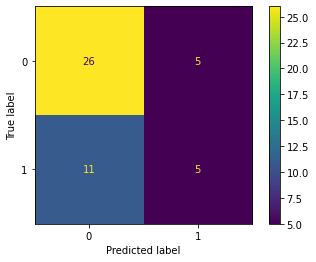

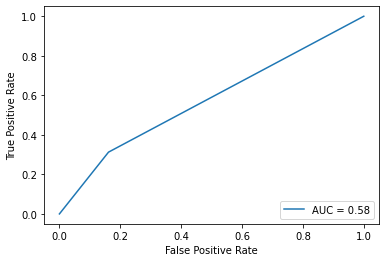

In [22]:
evaluate(Y_validation, predictions)

### Melhorando o modelo

In [23]:
# guardando nome das colunas com 5% de importância ou menos
least_important = []
for X in X_importances:
    if X[1] <= 0.1:
        least_important.append(X[0])

# retirando as colunas do conjunto de dados
limited_dataset = dataset.drop(least_important, axis=1)

# extraindo novamente as variáveis preditoras com seus nomes
new_X_names = list(limited_dataset.columns)
new_X = np.array(limited_dataset)

# 90% para treino e 10% para validação
new_X_train, new_X_validation, new_Y_train, new_Y_validation = train_test_split(
        new_X, y, test_size=0.10, random_state=1)

# validação cruzada em 10 rodadas
kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_results = cross_val_score(model, new_X_train, new_Y_train, cv=kfold, scoring='roc_auc')
# treinamento do modelo
model.fit(new_X_train, new_Y_train)

# predições 
predictions = model.predict(new_X_validation)

#### Resultados para avaliação

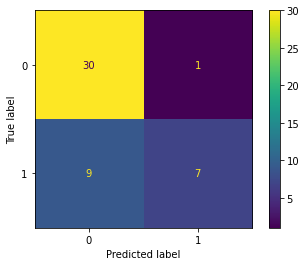

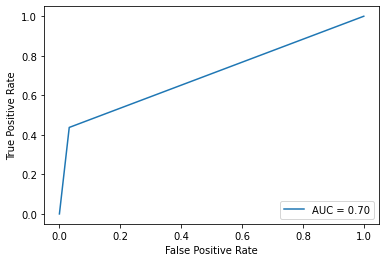

In [24]:
evaluate(new_Y_validation, predictions)

In [25]:
# Impressão das duas variáveis mais importantes
# fonte: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# lista numérica de variáveis mais importantes gerada pelo scikitlearn 
importances = list(model.feature_importances_)

# lista de tuplas com nomes da variável e sua importancia
X_importances = [(X, round(importance, 2)) for X, importance in zip(X_names, importances)]

# ordenação
X_importances = sorted(X_importances, key = lambda x: x[1], reverse = True)

# impressão das duas variáveis mais importantes
for par in X_importances:
    print('{:20} Importância: {}'.format(*par))

tobacco              Importância: 0.21
ldl                  Importância: 0.21
typea                Importância: 0.21
sbp                  Importância: 0.2
adiposity            Importância: 0.17
